#### Assignment 0.1: Load the Auto dataset into R or Python.

In [1]:
import pandas as pd

df = pd.read_csv('https://www.statlearning.com/s/Auto.csv')

#### Assignment 0.2: Drop all variables except the (potential) predictors ['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'year'] and the target variable 'mpg'.

In [2]:
predictors = ['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'year']
target = 'mpg'

df = df[predictors + [target]]

#### Assignment 0.3: Split the dataset into a training set (80%) and a validation set (20%). It is probably a good idea to set a random seed and shuffle the dataset prior to this.

In [3]:
import numpy as np

np.random.seed(42)

df = df.sample(frac=1.0)
train_length = int(len(df) * 0.8)
train = df[:train_length].copy()
validation = df[train_length:].copy()

print(f'Using {len(train)} samples for training')
print(f'Using {len(validation)} samples for validation')

Using 317 samples for training
Using 80 samples for validation


#### Assignment 0.4: Replace missing values (coded as '?') in the both datasets with the mean of the given variable in the training set.

In [4]:
for column in train.columns:
    if '?' in train[column].values or '?' in validation[column].values:
        train_mean = np.nanmean(pd.to_numeric(train[column], errors='coerce'))
        train.loc[train[column] == '?', column] = train_mean
        validation.loc[validation[column] == '?', column] = train_mean

#### Assignment 0.5: Standardize the predictors in the training set using z-score standardization.
#### Assignment 0.6: Standardize the predictors in validation set based on the means and standard deviations from the training set.

In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train[predictors] = scaler.fit_transform(train[predictors])
validation[predictors] = scaler.transform(validation[predictors])

#### Assignment 0.7: Reflection: Discuss briefly why it is a good idea (or even necessary?) to standardize the variables before fitting the LASSO models in assignment 2. Why do we mean-fill and standardize the validation set based on information from the training set?

- We standardize the variables before the LASSO to ensure that predictors that might originally have different magnitudes are penalized equally
- We mean-fill and standardize the validation set based on information from the training set to ensure they are preprocessed in a consistent ways (i.e. NA in both sets prior to preprocessing maps onto the same value after preprocessing) and to avoid data leakage

#### Assignment 1.1: Find the optimal set of predictors of size [6, 5, 4, 3, 2, 1] based on model performance using backwards stepwise selection. Print out each set.

In [6]:
from copy import copy
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


current_predictors = copy(predictors)
models = []

def fit_and_validate(train, validation, predictors, target):
    model = LinearRegression()
    model.fit(train[predictors], train[target])
    predictions = model.predict(validation[predictors])

    return mean_squared_error(predictions, validation[target])

def find_worst_predictor(train, validation, predictors, target):
    best_mse = float('inf')
    worst_predictor = None
    
    for candidate in predictors:
        selected = [predictor for predictor in predictors if predictor != candidate]
        mse = fit_and_validate(train, validation, selected, target)

        if mse < best_mse:
            best_mse = mse
            worst_predictor = candidate

    return worst_predictor 

while len(current_predictors) > 0:
    print(current_predictors)
    model = LinearRegression()
    model.fit(train[current_predictors], train[target])
    models.append(model)

    if len(current_predictors) == 1:
        break
    
    worst_predictor = find_worst_predictor(train, validation, current_predictors, target)
    current_predictors = [
        predictor for predictor in current_predictors if predictor != worst_predictor
    ]

['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'year']
['cylinders', 'displacement', 'weight', 'acceleration', 'year']
['cylinders', 'weight', 'acceleration', 'year']
['weight', 'acceleration', 'year']
['weight', 'year']
['weight']


#### Assignment 1.2: Based on the models you have already trained, plot both training and validation MSE as a function of the number of predictors.

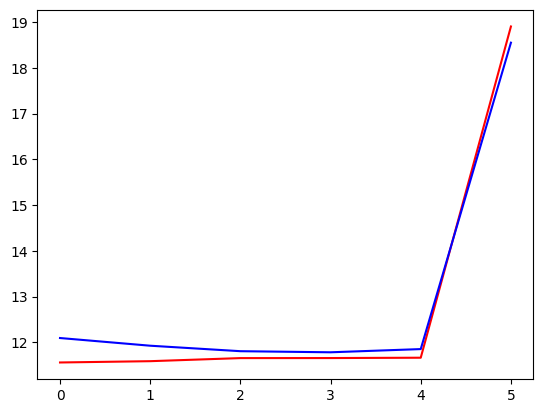

In [7]:
import matplotlib.pyplot as plt

training_mses = [
    mean_squared_error(model.predict(train[model.feature_names_in_]), train[target]) 
    for model in models
]
validation_mses = [
    mean_squared_error(model.predict(validation[model.feature_names_in_]), validation[target]) 
    for model in models
]

plt.plot(np.arange(len(models)), training_mses, c='red', label='Train')
plt.plot(np.arange(len(models)), validation_mses, c='blue', label='Validation')
plt.show()

#### Assignment 1.3: Plot mpg predictions against actual mpg values for the validation set using the best model.

Best predictor set: ['weight' 'acceleration' 'year'] (MSE=11.78)


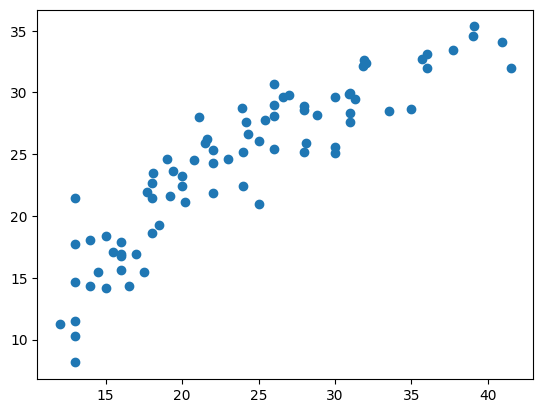

In [8]:
best_idx = np.argmin(validation_mses)
best_model = models[best_idx]
print(f'Best predictor set: {best_model.feature_names_in_} (MSE={validation_mses[best_idx]:.2f})')
predictions = best_model.predict(validation[best_model.feature_names_in_])

plt.scatter(validation[target], predictions)
plt.show()

#### Assignment 1.4: Reflection: What is the best model based on training MSE? What about validation MSE? If they are different, reflect briefly on why. If not, could this happen? Why/why not?

The best model based on training MSE will always be the model with the most predictors. This is not necessarily the case for the validation set, where there is a potential that more predictors lead to more overfitting. Thus, we expect the validation performance to follow a U-shaped curve as a function of the number of predictors

#### Assignment 2.1: Fit a range of LASSO models to predict mpg using all the predictors, with eleven lambdas uniformly spaced between 0 and 10 (e.g. 0, 1, 2, ..., 9, 10)

In [9]:
from sklearn.linear_model import Lasso

lambdas = np.arange(1, 11)

models = []
train_predictions = []
validation_predictions = []

for value in lambdas:
    model = Lasso(alpha=value)
    model.fit(train[predictors], train[target])
    models.append(model)
    train_predictions.append(model.predict(train[predictors]))
    validation_predictions.append(model.predict(validation[predictors]))

#### Assignment 2.2: Plot the train and validation MSE as a function of the value of lambda

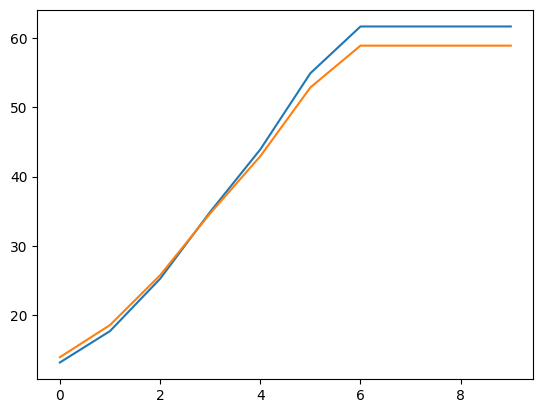

In [10]:
train_mses = [mean_squared_error(predictions, train[target]) for predictions in train_predictions]
validation_mses = [
    mean_squared_error(predictions, validation[target]) 
    for predictions in validation_predictions
]

plt.plot(np.arange(len(lambdas)), train_mses)
plt.plot(np.arange(len(lambdas)), validation_mses)
plt.show()

#### Assignment 2.3: Using the values plotted in b), print the lambda yielding the best model based on training MSE and validation MSE, and their corresponding MSE values.

In [11]:
best_train_idx = np.argmin(train_mses)
print(f'Best train lambda: {lambdas[best_train_idx]} ({train_mses[best_train_idx]})')
best_validation_idx = np.argmin(validation_mses)
print(f'Best train lambda: {lambdas[best_validation_idx]} ({validation_mses[best_validation_idx]})')

Best train lambda: 1 (13.173154234238629)
Best train lambda: 1 (13.934642861305974)


#### Assignment 2.4: Reflection: Is the best model based on training MSE and validation MSE using the same lambda? If not, why not? What would be the general pattern we expect to see here?

The best model based on training MSE will always be the model with the lowest lambda, as this a lower lambda means the model is prioritizing fitting the (training) data better. This is not necessarily the case for the validation data, as a lower lambda is also prone to overfitting. Thus, we expect to see a U-shaped pattern if we plot the validation predictions as a function of lambda. In this specific case, the pattern we see doesn't really resemble a U. This is because the selection of lambdas is somewhat poor, and a more appropriate range could have been [0.1, 0.2, 0.3, ...] or something even smaller.

#### Assignment 2.5: Plot predictions against actual values and for the validation set using the best model.

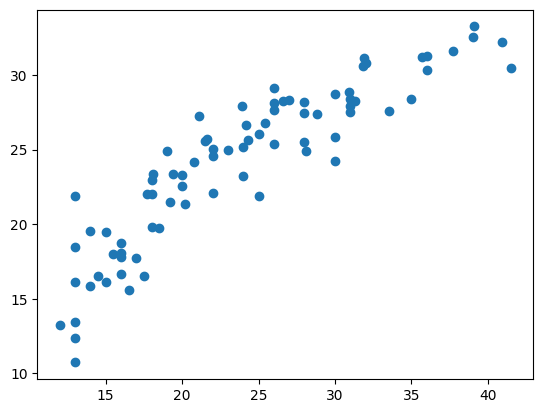

In [12]:
plt.scatter(validation[target], validation_predictions[best_validation_idx])
plt.show()

#### Assignment 2.6: Reflection: Is the best LASSO model better or worse than the best model found using backward stepwise selection? Discuss briefly why this is/is not the case.

It is generally not necessarily so that the two methods find the same best model, as they approach the problem from very different angles. In addition to differences caused by this, it is worth emphasizing that the best model found using LASSO will also impose regularization on the variables that remain in the model, such that even when the predictor sets end up the same, the overall models will typically behave slightly differently. Whether this is beneficial or not will depend on the exact dataset at hand.

#### Assignment 2.7: Print the names and coefficients of the predictors that are used by the LASSO model (e.g. not set to 0). How does this compare to the list you found using backwards stepwise selection?

In [121]:
best_model = models[best_validation_idx]
print([
    best_model.feature_names_in_[i] 
    for i in range(len(best_model.feature_names_in_))
    if best_model.coef_[i] != 0
])

['weight', 'year']
